# Lab3 Model Quantization
## Setup
### Install python package

In [1]:
!pip install torch
!pip install torchinfo
!pip install torchsummary
!pip install torchvision
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

### Environment Setup

In [2]:
import os
import math
import copy
import time
import torch
import platform
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.ao.quantization as tq

from enum import Enum
from tqdm import tqdm
from typing import Tuple
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

# Select device
DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set environment variable to enable expandable segments for CUDA allocator
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Ignore warnings in Pytorch2.8 when using torch.ao.quantization
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set quantization backend based on CPU architecture
machine = platform.machine().lower()
if "x86" in machine or "amd64" in machine:
    torch.backends.quantized.engine = 'fbgemm'
elif "arm" in machine or "aarch64" in machine:
    torch.backends.quantized.engine = 'qnnpack'
else:
    print("Unsupported machine:", machine)

# Check environment information
print("Pytorch version:", torch.__version__)
print(f"Using {torch.backends.quantized.engine} backend {machine}")
print("Using device:", DEFAULT_DEVICE)

Pytorch version: 2.8.0+cu126
Using fbgemm backend x86_64
Using device: cuda


### Load CIFAR-10 Dataset

In [3]:
def get_loaders(
    source, batch_size: int, transform, eval_transform=None,
    root: str = "data", split_ratio: float = 0.1
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    if eval_transform is None:
        eval_transform = transform

    trainset = source(root=root, train=True, download=True, transform=transform)
    testset  = source(root=root, train=False, download=True, transform=eval_transform)

    val_len = int(split_ratio * len(trainset))
    train_len = len(trainset) - val_len
    trainset, valset = torch.utils.data.random_split(trainset, [train_len, val_len])

    loader_kwargs = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    trainloader = DataLoader(trainset, shuffle=True, **loader_kwargs)
    valloader  = DataLoader(valset, shuffle=True, **loader_kwargs)
    testloader = DataLoader(testset, shuffle=False, **loader_kwargs)

    return trainloader, valloader, testloader

def get_cifar10_loaders(batch_size: int, root="data/cifar10", split_ratio: float = 0.1):
    """
    Create CIFAR-10 training / validation / testing dataloaders.

    Args:
        batch_size (int): Number of samples per mini-batch.
        root (str): Path to download/load CIFAR-10 dataset.
        split_ratio (float): Fraction of training set to use for validation.

    Returns:
        train_loader, val_loader, test_loader (torch.utils.data.DataLoader)
    """

    # CIFAR-10 數據集的標準平均值和標準差
    cifar10_mean = [0.4914, 0.4822, 0.4465]
    cifar10_std = [0.2023, 0.1994, 0.2010]

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),      # 隨機裁切 (32x32)
        transforms.RandomHorizontalFlip(),         # 隨機水平翻轉
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std),
    ])

    eval_transform = transforms.Compose([
        ##### YOUR CODE HERE #####
        # Evaluation transform
        transforms.ToTensor(),                     # 轉換為 Tensor
        transforms.Normalize(cifar10_mean, cifar10_std), # 標準化 (使用與訓練集相同的參數)
    ])

    return get_loaders(
        datasets.CIFAR10, batch_size, train_transform,
        eval_transform=eval_transform, root=root, split_ratio=split_ratio
    )

if __name__ == "__main__":

    """ You can adjust the numbers below """
    BATCH_SIZE = 64
    VAL_TRAIN_SPLIT_RATIO = 0.1

    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE, split_ratio=VAL_TRAIN_SPLIT_RATIO)
    print(f"CIFAR-10: train={len(train_loader.dataset)}, "
            f"val={len(val_loader.dataset)}, "
            f"test={len(test_loader.dataset)}, "
            f"shape={train_loader.dataset[0][0].shape}")

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


CIFAR-10: train=45000, val=5000, test=10000, shape=torch.Size([3, 32, 32])


## Model Preparation
### Implement ResNet-50

In [4]:
class QuantizableBasicBlock(nn.Module):
    """
    BasicBlock for ResNet with quantization support.
    """

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # ----- Convolution + BatchNorm + ReLU -----
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=False)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

        # FloatFunctional() allows fused add+relu in quantized models
        self.add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        ##### YOUR CODE HERE #####
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) # <--- 使用 self.relu

        out = self.conv2(out)
        out = self.bn2(out)
        # <--- BasicBlock 的第二層 conv 後沒有 ReLU，ReLU 是和 Add 一起做的
        ##### END YOUR CODE #####

        if self.downsample is not None:
            identity = self.downsample(x)

        ##### YOUR CODE HERE #####
        # out = add + relu (skip connection)
        # 這裡使用 self.add_relu.add_relu() 來執行 Add 和 ReLU
        out = self.add_relu.add_relu(out, identity)
        ##### END YOUR CODE #####

        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """

        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        # 融合第一組：conv1, bn1, relu
        # 融合第二組：conv2, bn2 (後面沒有獨立的 ReLU)
        modules_to_fuse = [
            ['conv1', 'bn1', 'relu'],
            ['conv2', 'bn2']
        ]
        torch.ao.quantization.fuse_modules(self, modules_to_fuse, inplace=True)
        ##### END YOUR CODE #####

        if self.downsample:
            ##### YOUR CODE HERE #####
            # Fuse downsample conv+bn if exists
            # downsample 在 _make_layer 中被定義為 nn.Sequential(nn.Conv2d, nn.BatchNorm2d)
            # 所以我們融合 '0' (Conv2d) 和 '1' (BatchNorm2d)
            torch.ao.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)
            ##### END YOUR CODE #####
            pass


class QuantizableBottleneck(nn.Module):
    """
    Bottleneck block for ResNet with quantization support.
    """

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # 1x1 reduce
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 conv
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 1x1 expand
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

        self.downsample = downsample
        self.stride = stride

        # FloatFunctional for quantized skip connection
        self.skip_add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        ##### YOUR CODE HERE #####
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)


        if self.downsample is not None:
            identity = self.downsample(x)

        ##### YOUR CODE HERE #####
        # out = add + relu (skip connection)
        # 使用 self.skip_add_relu.add_relu() 來取代 (out + identity) 再加上 F.relu()
        out = self.skip_add_relu.add_relu(out, identity)
        ##### END YOUR CODE #####

        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """
        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        # 融合主路徑的三組 Conv-BN-ReLU (或 Conv-BN)
        modules_to_fuse = [
            ['conv1', 'bn1', 'relu1'],
            ['conv2', 'bn2', 'relu2'],
            ['conv3', 'bn3'] # conv3 後面沒有獨立的 ReLU
        ]
        torch.ao.quantization.fuse_modules(self, modules_to_fuse, inplace=True)
        ##### END YOUR CODE #####

        if self.downsample:
            ##### YOUR CODE HERE #####
            # Fuse downsample conv+bn if exists
            # 融合 downsample 裡的 '0' (Conv2d) 和 '1' (BatchNorm2d)
            torch.ao.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)
            ##### END YOUR CODE #####
            pass

class QuantizableResNet(nn.Module):
    """
    ResNet model adapted for CIFAR-10 and quantization.
    """

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.inplanes = 64

        # CIFAR-10 uses 3x3 conv instead of 7x7
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.Identity() # no pooling for CIFAR-10

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Quantization stubs
        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

    def _make_layer(self, block, planes, blocks, stride=1):
        """
        Helper function to build ResNet layers.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        ##### YOUR CODE HERE #####
        # Quantize input
        x = self.quant(x)

        # conv1 -> bn1 -> relu
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # 雖然是 Identity()，但還是照順序放
        ##### END YOUR CODE #####

        # Pass through 4 residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classification head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        ##### YOUR CODE HERE #####
        # Dequantize output
        x = self.dequant(x)
        ##### END YOUR CODE #####

        return x

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU layers in ResNet.
        """
        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        # 融合模型入口的第一組 conv-bn-relu
        torch.ao.quantization.fuse_modules(self, ['conv1', 'bn1', 'relu'], inplace=True)
        ##### END YOUR CODE #####

        for m in self.modules():
            if type(m) is QuantizableBottleneck or type(m) is QuantizableBasicBlock:
                m.fuse_model()


def resnet50_cifar10() -> QuantizableResNet:
    """
    Construct a ResNet-50 for CIFAR-10 with quantization support.
    """
    model = QuantizableResNet(QuantizableBottleneck, [3, 4, 6, 3], num_classes=10)
    return model

### Inspect Model Architecture

In [5]:
if __name__ == "__main__":
    model = resnet50_cifar10()
    summary(model, (3, 32, 32), device= 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,728
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
          Identity-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]           4,096
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
           Conv2d-14          [-1, 256,

## Utilities

In [6]:
def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")

def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")

def save_model(model, filename: str, verbose: bool = True, existed: str = "keep_both") -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")

def load_model(model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_module"):
        print("Fusing modules")
        model.to('cpu').eval()
        model.fuse_model()

    if qconfig is not None:
        model.qconfig = qconfig
        qconfig_dict = {"": qconfig}
        model2 = copy.deepcopy(model)
        model_prepared = tq.prepare(model2, qconfig_dict)
        model_int8 = tq.convert(model_prepared)
        model_int8.load_state_dict(torch.load(filename, map_location='cpu', weights_only=False))
        model_int8.eval()
    else:
        device = DEFAULT_DEVICE if qconfig is None else 'cpu'
        model.load_state_dict(torch.load(filename, map_location=device, weights_only=False))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model

## Train Model
### Evaluate Function

In [7]:
def evaluate(model, dataloader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total * 100
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix

### Custom Learning Rate Scheduler

In [8]:
##### YOUR CODE HERE #####
# Optional

### Training Loop

In [9]:
def train_model(model, train_loader, val_loader,
                epochs=70, lr=0.1,
                is_qat: bool = False, device=DEFAULT_DEVICE):
    """
    Train the model across multiple epochs and validate after each epoch.

    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        epochs (int): Number of epochs to train.
        warmup_epochs (int): Warm-up epochs before cosine annealing.
        lr (float): Learning rate.
        is_qat (bool): Whether this is QAT training.
        device (str): Training device.

    Returns:
        model (nn.Module): Trained model.
    """

    ##### YOUR CODE HERE #####
    # Implement ypur criterion, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


    best_val_acc = 0.0
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            ##### YOUR CODE HERE #####
            # 1. Zero optimizer gradients
            optimizer.zero_grad()

            # 2. Forward pass
            outputs = model(images)

            # 3. Compute loss
            loss = criterion(outputs, labels)
            # 4. Backward pass
            loss.backward()
            # 5. Optimizer step
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({"loss": running_loss / total})

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----- Validation -----
        ##### YOUR CODE HERE #####
        val_loss, val_acc, _ = evaluate(model, val_loader, criterion, device)


        # Save history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc / 100.0)

        print(f"Epoch {epoch+1} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if not is_qat:
                save_model(model, "./weights/best_resnet50_cifar10.pth", existed="overwrite")
            else:
                save_model(model, "./weights/QAT_resnet50_cifar10.pth", existed="overwrite")

        if scheduler is not None:
            ##### YOUR CODE HERE #####
            scheduler.step()


    # ----- Plot loss/accuracy after training -----
    if not is_qat:
        plot_file = "./results/loss_accuracy.png"
    else:
        plot_file = "./results/QAT_loss_accuracy.png"

    plot_loss_accuracy(
        train_loss_history, train_acc_history,
        val_loss_history, val_acc_history,
        filename=plot_file
    )

    return model

### Hyperparameter Configuration

Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.47it/s]


Epoch 1 | Train Loss: 2.6740 | Train Acc: 11.67% | Val Loss: 2.2802 | Val Acc: 11.98%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.84it/s]


Epoch 2 | Train Loss: 2.1801 | Train Acc: 17.92% | Val Loss: 2.1191 | Val Acc: 20.28%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.15it/s]


Epoch 3 | Train Loss: 2.0860 | Train Acc: 22.09% | Val Loss: 2.0777 | Val Acc: 22.84%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.80it/s]


Epoch 4 | Train Loss: 1.9726 | Train Acc: 29.73% | Val Loss: 2.0348 | Val Acc: 28.54%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.93it/s]


Epoch 5 | Train Loss: 1.7851 | Train Acc: 40.32% | Val Loss: 1.8978 | Val Acc: 39.52%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.83it/s]


Epoch 6 | Train Loss: 1.6276 | Train Acc: 48.53% | Val Loss: 1.6475 | Val Acc: 47.68%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.63it/s]


Epoch 7 | Train Loss: 1.5288 | Train Acc: 53.52% | Val Loss: 1.6542 | Val Acc: 49.24%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.99it/s]


Epoch 8 | Train Loss: 1.4750 | Train Acc: 55.93% | Val Loss: 1.6874 | Val Acc: 46.68%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.65it/s]


Epoch 9 | Train Loss: 1.4319 | Train Acc: 57.90% | Val Loss: 1.6147 | Val Acc: 51.14%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.97it/s]


Epoch 10 | Train Loss: 1.3942 | Train Acc: 60.06% | Val Loss: 1.7730 | Val Acc: 47.16%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 11 | Train Loss: 1.3579 | Train Acc: 61.55% | Val Loss: 1.4317 | Val Acc: 58.50%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.92it/s]


Epoch 12 | Train Loss: 1.3221 | Train Acc: 63.48% | Val Loss: 1.5720 | Val Acc: 55.28%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Epoch 13 | Train Loss: 1.2923 | Train Acc: 64.92% | Val Loss: 1.3577 | Val Acc: 61.70%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 14 | Train Loss: 1.2580 | Train Acc: 66.64% | Val Loss: 1.7244 | Val Acc: 51.30%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.36it/s]


Epoch 15 | Train Loss: 1.2334 | Train Acc: 67.54% | Val Loss: 1.3453 | Val Acc: 61.70%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 16 | Train Loss: 1.2161 | Train Acc: 68.55% | Val Loss: 1.5565 | Val Acc: 53.38%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 17 | Train Loss: 1.1996 | Train Acc: 69.30% | Val Loss: 1.2838 | Val Acc: 66.02%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.98it/s]


Epoch 18 | Train Loss: 1.1915 | Train Acc: 69.66% | Val Loss: 1.2148 | Val Acc: 68.66%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.09it/s]


Epoch 19 | Train Loss: 1.1710 | Train Acc: 70.63% | Val Loss: 1.2988 | Val Acc: 64.52%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


Epoch 20 | Train Loss: 1.1628 | Train Acc: 70.99% | Val Loss: 1.3660 | Val Acc: 63.22%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Epoch 21 | Train Loss: 1.1579 | Train Acc: 71.11% | Val Loss: 1.2550 | Val Acc: 66.94%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.91it/s]


Epoch 22 | Train Loss: 1.1418 | Train Acc: 71.85% | Val Loss: 1.7097 | Val Acc: 50.16%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.74it/s]


Epoch 23 | Train Loss: 1.1329 | Train Acc: 72.44% | Val Loss: 1.2606 | Val Acc: 66.98%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.91it/s]


Epoch 24 | Train Loss: 1.1263 | Train Acc: 72.58% | Val Loss: 1.2439 | Val Acc: 67.98%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


Epoch 25 | Train Loss: 1.1151 | Train Acc: 73.20% | Val Loss: 1.2530 | Val Acc: 66.74%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.00it/s]


Epoch 26 | Train Loss: 1.1053 | Train Acc: 73.52% | Val Loss: 1.1695 | Val Acc: 71.26%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.73it/s]


Epoch 27 | Train Loss: 1.0945 | Train Acc: 74.12% | Val Loss: 1.2854 | Val Acc: 66.40%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.88it/s]


Epoch 28 | Train Loss: 1.0924 | Train Acc: 74.08% | Val Loss: 1.1707 | Val Acc: 70.10%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.65it/s]


Epoch 29 | Train Loss: 1.0869 | Train Acc: 74.28% | Val Loss: 1.1510 | Val Acc: 71.08%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


Epoch 30 | Train Loss: 1.0722 | Train Acc: 75.23% | Val Loss: 1.3061 | Val Acc: 65.42%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.85it/s]


Epoch 31 | Train Loss: 1.0599 | Train Acc: 75.46% | Val Loss: 1.1590 | Val Acc: 70.90%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.68it/s]


Epoch 32 | Train Loss: 1.0569 | Train Acc: 75.68% | Val Loss: 1.3278 | Val Acc: 64.56%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch 33 | Train Loss: 1.0529 | Train Acc: 75.73% | Val Loss: 1.1625 | Val Acc: 70.60%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 34 | Train Loss: 1.0424 | Train Acc: 76.35% | Val Loss: 1.1602 | Val Acc: 70.76%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.75it/s]


Epoch 35 | Train Loss: 1.0241 | Train Acc: 77.11% | Val Loss: 1.1082 | Val Acc: 73.02%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.84it/s]


Epoch 36 | Train Loss: 1.0193 | Train Acc: 77.35% | Val Loss: 1.1523 | Val Acc: 71.72%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.75it/s]


Epoch 37 | Train Loss: 1.0071 | Train Acc: 77.88% | Val Loss: 1.0990 | Val Acc: 73.08%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.96it/s]


Epoch 38 | Train Loss: 1.0008 | Train Acc: 78.10% | Val Loss: 1.0797 | Val Acc: 74.64%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


Epoch 39 | Train Loss: 0.9918 | Train Acc: 78.62% | Val Loss: 1.0618 | Val Acc: 74.46%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


Epoch 40 | Train Loss: 0.9793 | Train Acc: 79.08% | Val Loss: 1.0629 | Val Acc: 74.36%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Epoch 41 | Train Loss: 0.9697 | Train Acc: 79.41% | Val Loss: 1.0135 | Val Acc: 77.18%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.84it/s]


Epoch 42 | Train Loss: 0.9642 | Train Acc: 79.59% | Val Loss: 1.0484 | Val Acc: 75.38%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.76it/s]


Epoch 43 | Train Loss: 0.9546 | Train Acc: 80.24% | Val Loss: 1.0851 | Val Acc: 73.88%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 44 | Train Loss: 0.9401 | Train Acc: 80.55% | Val Loss: 0.9982 | Val Acc: 78.28%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 45 | Train Loss: 0.9244 | Train Acc: 81.58% | Val Loss: 1.0427 | Val Acc: 77.18%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.18it/s]


Epoch 46 | Train Loss: 0.9170 | Train Acc: 81.88% | Val Loss: 0.9986 | Val Acc: 78.22%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


Epoch 47 | Train Loss: 0.9068 | Train Acc: 82.18% | Val Loss: 0.9808 | Val Acc: 79.12%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.86it/s]


Epoch 48 | Train Loss: 0.8904 | Train Acc: 83.10% | Val Loss: 0.9343 | Val Acc: 80.54%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 49 | Train Loss: 0.8823 | Train Acc: 83.27% | Val Loss: 0.9633 | Val Acc: 78.96%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


Epoch 50 | Train Loss: 0.8677 | Train Acc: 83.99% | Val Loss: 0.9174 | Val Acc: 81.66%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 51 | Train Loss: 0.8550 | Train Acc: 84.57% | Val Loss: 0.9402 | Val Acc: 80.78%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


Epoch 52 | Train Loss: 0.8416 | Train Acc: 85.20% | Val Loss: 0.8846 | Val Acc: 83.10%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


Epoch 53 | Train Loss: 0.8326 | Train Acc: 85.57% | Val Loss: 0.9055 | Val Acc: 82.10%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.88it/s]


Epoch 54 | Train Loss: 0.8174 | Train Acc: 86.12% | Val Loss: 0.8842 | Val Acc: 82.76%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


Epoch 55 | Train Loss: 0.8067 | Train Acc: 86.63% | Val Loss: 0.8665 | Val Acc: 83.84%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.15it/s]


Epoch 56 | Train Loss: 0.7917 | Train Acc: 87.34% | Val Loss: 0.8402 | Val Acc: 84.58%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.92it/s]


Epoch 57 | Train Loss: 0.7726 | Train Acc: 88.18% | Val Loss: 0.8223 | Val Acc: 85.14%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


Epoch 58 | Train Loss: 0.7586 | Train Acc: 88.72% | Val Loss: 0.8567 | Val Acc: 83.92%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.77it/s]


Epoch 59 | Train Loss: 0.7440 | Train Acc: 89.43% | Val Loss: 0.8101 | Val Acc: 86.32%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.78it/s]


Epoch 60 | Train Loss: 0.7310 | Train Acc: 90.08% | Val Loss: 0.7991 | Val Acc: 87.02%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.57it/s]


Epoch 61 | Train Loss: 0.7175 | Train Acc: 90.59% | Val Loss: 0.7856 | Val Acc: 87.02%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.70it/s]


Epoch 62 | Train Loss: 0.7023 | Train Acc: 91.19% | Val Loss: 0.7736 | Val Acc: 88.02%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.80it/s]


Epoch 63 | Train Loss: 0.6824 | Train Acc: 92.08% | Val Loss: 0.7629 | Val Acc: 88.54%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.57it/s]


Epoch 64 | Train Loss: 0.6718 | Train Acc: 92.62% | Val Loss: 0.7499 | Val Acc: 89.26%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.85it/s]


Epoch 65 | Train Loss: 0.6619 | Train Acc: 93.05% | Val Loss: 0.7368 | Val Acc: 89.50%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Epoch 66 | Train Loss: 0.6534 | Train Acc: 93.41% | Val Loss: 0.7502 | Val Acc: 89.62%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.04it/s]


Epoch 67 | Train Loss: 0.6445 | Train Acc: 93.75% | Val Loss: 0.7220 | Val Acc: 89.98%
Model saved at ./weights/best_resnet50_cifar10.pth (94.408403 MB)


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


Epoch 68 | Train Loss: 0.6369 | Train Acc: 94.06% | Val Loss: 0.7320 | Val Acc: 89.60%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 15.85it/s]


Epoch 69 | Train Loss: 0.6328 | Train Acc: 94.35% | Val Loss: 0.7263 | Val Acc: 89.88%


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Epoch 70 | Train Loss: 0.6356 | Train Acc: 94.11% | Val Loss: 0.7332 | Val Acc: 89.58%
Plot saved at ./results/loss_accuracy.png


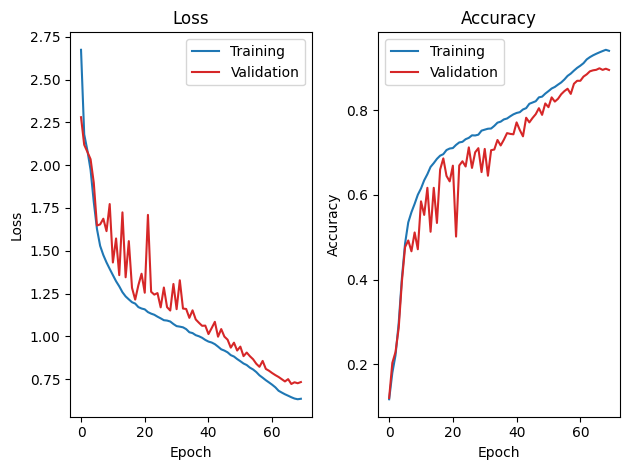

In [10]:
if __name__ == "__main__":

    """ You can adjust the numbers below """
    EPOCHS = 70
    LEARNING_RATE = 0.1


    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE, split_ratio=VAL_TRAIN_SPLIT_RATIO)
    model = resnet50_cifar10().to(DEFAULT_DEVICE)
    train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

### Model Testing

Evaluating: 100%|██████████| 157/157 [00:09<00:00, 16.75it/s]


Test Accuracy: 93.96% | Loss: 0.2647
Confusion matrix saved to ./results/confusion_matrix.png


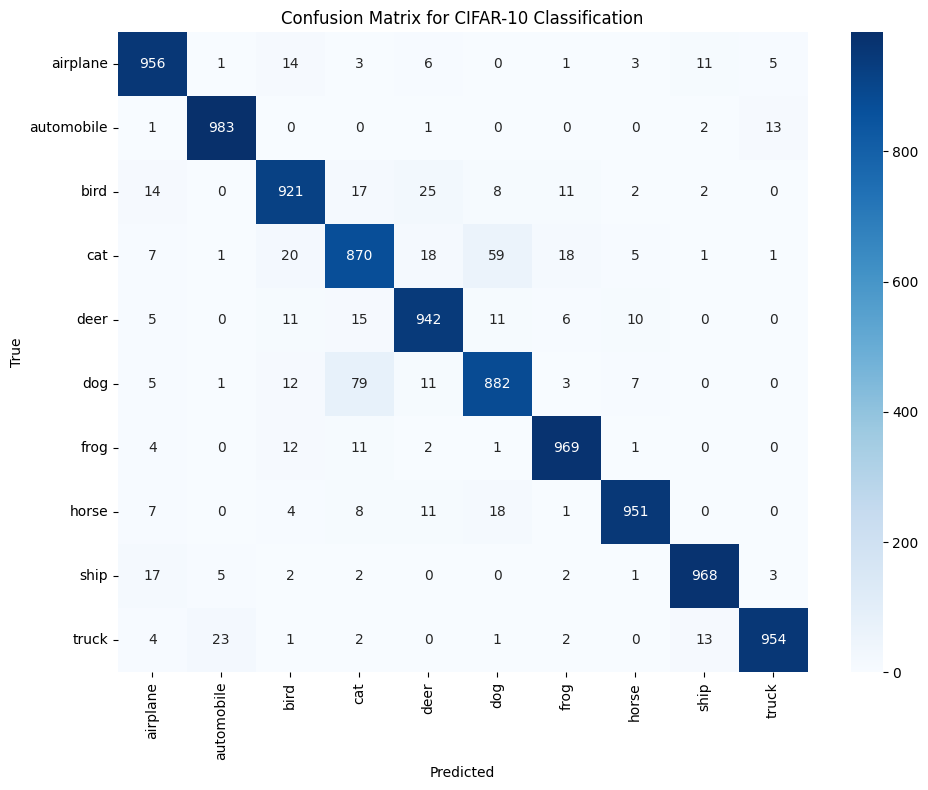

In [11]:
if __name__ == "__main__":

    ##### YOUR CODE HERE #####
    # Implement your criterion
    criterion = nn.CrossEntropyLoss()

    model = resnet50_cifar10().to(DEFAULT_DEVICE)
    model = load_model(model, "./weights/best_resnet50_cifar10.pth", verbose=False)
    avg_loss, test_acc, conf_matrix = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_acc:.2f}% | Loss: {avg_loss:.4f}")
    plot_confusion_matrix(conf_matrix, filename="./results/confusion_matrix.png")

## Post-Training Quantization (PTQ)
### Implement Quantization Function

In [12]:
class CusQuantObserver(tq.MinMaxObserver):
    """
    Observer module for your customized customize quantization scheme.
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        ##### YOUR CODE HERE #####
        if scale <= 0.0 :
            return 1.0
        # 1. Find S such that scale ≈ 2**(-S)
        #    log2(scale) ≈ -S
        #    S ≈ -log2(scale)
        S = round(-math.log2(scale))
        # 2. Clamp S to the range [0, max_shift_amount]
        S_clamped = max(0,min(S,max_shift_amount))
        new_scale = 2.0 ** (-S_clamped)

        return new_scale
    def calculate_qparams(self):
        """Calculates the quantization parameters with scale."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        ##### YOUR CODE HERE #####
        qmin, qmax = self.quant_min, self.quant_max
        qmin, qmax = float(qmin), float(qmax)

        if self.qscheme == torch.per_tensor_symmetric:
            max_abs_val = max(abs(min_val), abs(max_val))
            min_val, max_val = -max_abs_val, max_abs_val

        scale = (max_val - min_val) / (qmax - qmin)
        if abs(scale) < 1e-6:
            scale = 1.0

        if self.qscheme == torch.per_tensor_symmetric:
            if self.dtype == torch.qint8:
                zero_point = 0
            else:
                zero_point = 128
        else:
            zero_point = qmin - round(min_val / scale)
        #Clamp zero point
        zero_point = max(qmin,min(qmax,int(zero_point)))

        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=CustomQConfig"


class CustomQConfig(Enum):
    CusQuant = tq.QConfig(
        activation=CusQuantObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=CusQuantObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

### Evaluate Quantized Model

In [13]:
def test_performance(model_fp32, model_int8, dataloader, criterion,
                     is_ptq: bool = True,
                     fp32_file="./weights/best_resnet50_cifar10.pth",
                     int8_file="./weights/PTQ_resnet50_cifar10.pth"
                    ):

    device_fp32 = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_int8 = 'cpu'

    model_fp32.to(device_fp32)
    model_int8.to(device_int8)


    # ----- Test accuracy & loss -----
    print("Evaluating FP32 model...")
    loss_fp32, acc_fp32, _ = evaluate(model_fp32, dataloader, criterion, device=device_fp32)
    print(f"[FP32] Loss: {loss_fp32:.4f}, Accuracy: {acc_fp32:.2f}%")

    print("Evaluating INT8 model...")
    loss_int8, acc_int8, _ = evaluate(model_int8, dataloader, criterion, device=device_int8)
    if is_ptq:
        print(f"[PTQ INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")
    else:
        print(f"[QAT INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")


    # ----- Test latency -----
    model_fp32.to('cpu')
    dummy_input = torch.randn(1, 3, 32, 32).to('cpu')

    # FP32
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_fp32(dummy_input)
    t1 = time.time()
    fp32_time = (t1 - t0) / 1000

    # INT8
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_int8(dummy_input)
    t1 = time.time()
    int8_time = (t1 - t0) / 1000

    if is_ptq:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | PTQ INT8: {int8_time*1000:.3f} ms")
    else:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | QAT INT8: {int8_time*1000:.3f} ms")
    print(f"[Speedup] ~{fp32_time/int8_time:.2f}x faster")


    # ----- Compare file size -----
    if os.path.exists(fp32_file) and os.path.exists(int8_file):
        size_fp32 = os.path.getsize(fp32_file) / 1e6
        size_int8 = os.path.getsize(int8_file) / 1e6
        if is_ptq:
            print(f"[File size] FP32: {size_fp32:.2f} MB | PTQ INT8: {size_int8:.2f} MB")
        else:
            print(f"[File size] FP32: {size_fp32:.2f} MB | QAT INT8: {size_int8:.2f} MB")
        print(f"[Compression] ~{size_fp32/size_int8:.2f}x smaller")
    else:
        print("Warning: model files not found. Skipping file size comparison.")

### Run PTQ Workflow

In [14]:
def calibrate(model, loader, device= 'cpu'):
    """
    Run one pass of calibration on the dataset to collect statistics
    for quantization (e.g., min/max values of activations).

    Args:
        model (nn.Module): The model prepared for quantization.
        loader (DataLoader): Data loader for calibration dataset.
        device (str): Device to run calibration on.
    """
    ##### YOUR CODE HERE #####
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            _ = model(images)


def ptq_quantization():
    """
    Perform Post-Training Quantization (PTQ) on the trained ResNet-50 model.

    Steps:
        1. Load CIFAR-10 validation set
        2. Load trained FP32 model
        3. Fuse model layers
        4. Prepare model for PTQ
        5. Calibrate using validation data
        6. Convert model to INT8
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after PTQ
    """
    # 1. Data
    _, val_loader, _ = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)
    model_fp32.to('cpu')
    model_fp32.eval()

    ##### YOUR CODE HERE #####
    # 3. Fuse layers
    print("Fusing layers...")
    model_fp32.fuse_model()

    # 4. Prepare PTQ
    print("Preparing PTQ...")
    model_fp32.qconfig = CustomQConfig.CusQuant.value
    tq.prepare(model_fp32, inplace=True)

    # 5. Calibrate
    print("Calibrating...")
    calibrate(model_fp32, val_loader, device='cpu')

    # 6. Convert to INT8
    print("Converting to INT8...")
    model_int8 = tq.convert(model_fp32, inplace=False) #保留model
    model_int8.eval()

    # 7. Save INT8 model
    save_model(model_int8, "./weights/PTQ_resnet50_cifar10.pth", existed="overwrite")

    return model_int8

### Compare FP32 vs Quantized Results

In [15]:
if __name__ == "__main__":
    model_int8 = ptq_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    criterion = nn.CrossEntropyLoss()

    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=True)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=True)

Model loaded from ./weights/best_resnet50_cifar10.pth (94.408403 MB)
Fusing layers...
Preparing PTQ...
Calibrating...
Converting to INT8...
Model saved at ./weights/PTQ_resnet50_cifar10.pth (23.661131 MB)
Model loaded from ./weights/best_resnet50_cifar10.pth (94.408403 MB)
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:09<00:00, 16.75it/s]


[FP32] Loss: 0.2647, Accuracy: 93.96%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [04:27<00:00,  1.71s/it]


[PTQ INT8] Loss: 0.2805, Accuracy: 92.99%
[Latency] FP32: 62.421 ms | PTQ INT8: 32.477 ms
[Speedup] ~1.92x faster
[File size] FP32: 94.41 MB | PTQ INT8: 23.66 MB
[Compression] ~3.99x smaller


## Quantization-Aware Training (QAT)
### Run QAT Workflow

Model loaded from /content/weights/best_resnet50_cifar10.pth (94.408403 MB)
Fusing layers...
Setting qconfig for QAT...
Preparing model for QAT...
Training with QAT...


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.81it/s]


Epoch 1 | Train Loss: 0.6405 | Train Acc: 93.95% | Val Loss: 0.6445 | Val Acc: 93.74%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.47it/s]


Epoch 2 | Train Loss: 0.6357 | Train Acc: 94.20% | Val Loss: 0.6395 | Val Acc: 93.80%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.03it/s]


Epoch 3 | Train Loss: 0.6358 | Train Acc: 94.07% | Val Loss: 0.6468 | Val Acc: 93.52%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.82it/s]


Epoch 4 | Train Loss: 0.6361 | Train Acc: 94.01% | Val Loss: 0.6384 | Val Acc: 93.94%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.29it/s]


Epoch 5 | Train Loss: 0.6346 | Train Acc: 94.05% | Val Loss: 0.6460 | Val Acc: 93.48%


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.15it/s]


Epoch 6 | Train Loss: 0.6354 | Train Acc: 94.17% | Val Loss: 0.6444 | Val Acc: 93.90%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.78it/s]


Epoch 7 | Train Loss: 0.6330 | Train Acc: 94.28% | Val Loss: 0.6397 | Val Acc: 93.68%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


Epoch 8 | Train Loss: 0.6330 | Train Acc: 94.28% | Val Loss: 0.6405 | Val Acc: 93.88%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.37it/s]


Epoch 9 | Train Loss: 0.6323 | Train Acc: 94.27% | Val Loss: 0.6385 | Val Acc: 94.00%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.86it/s]


Epoch 10 | Train Loss: 0.6319 | Train Acc: 94.22% | Val Loss: 0.6409 | Val Acc: 94.02%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.67it/s]


Epoch 11 | Train Loss: 0.6349 | Train Acc: 94.13% | Val Loss: 0.6376 | Val Acc: 94.24%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.69it/s]


Epoch 12 | Train Loss: 0.6313 | Train Acc: 94.37% | Val Loss: 0.6319 | Val Acc: 94.38%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.210316 MB)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.72it/s]


Epoch 13 | Train Loss: 0.6326 | Train Acc: 94.32% | Val Loss: 0.6355 | Val Acc: 94.00%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.44it/s]


Epoch 14 | Train Loss: 0.6303 | Train Acc: 94.32% | Val Loss: 0.6460 | Val Acc: 93.76%


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.91it/s]


Epoch 15 | Train Loss: 0.6343 | Train Acc: 94.11% | Val Loss: 0.6494 | Val Acc: 93.86%
Plot saved at ./results/QAT_loss_accuracy.png
Converting to INT8...
Model saved at ./weights/QAT_resnet50_cifar10.pth (24.115695 MB)
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:09<00:00, 16.63it/s]


[FP32] Loss: 0.2647, Accuracy: 93.96%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [04:18<00:00,  1.65s/it]


[QAT INT8] Loss: 0.2507, Accuracy: 93.97%
[Latency] FP32: 59.416 ms | QAT INT8: 31.544 ms
[Speedup] ~1.88x faster
[File size] FP32: 94.41 MB | QAT INT8: 24.12 MB
[Compression] ~3.91x smaller


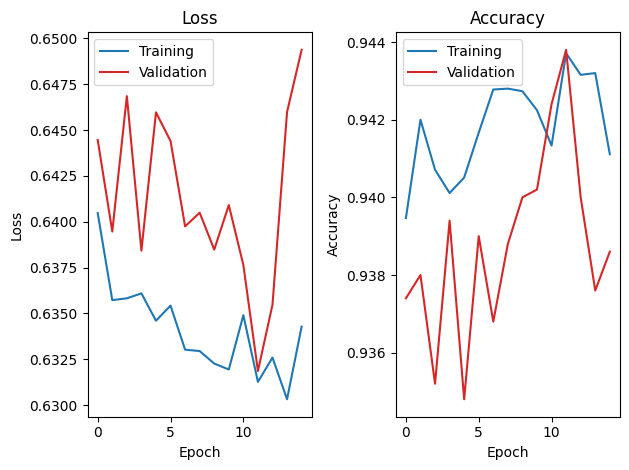

In [16]:
def qat_quantization():
    """
    Run Quantization-Aware Training (QAT) workflow on ResNet-50 for CIFAR-10.

    Steps:
        0. Prepare CIFAR-10 dataloaders
        1. Load pretrained FP32 model
        2. Fuse model layers
        3. Assign QAT qconfig
        4. Prepare model for QAT
        5. Train with QAT
        6. Convert to INT8 model
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after QAT
    """
    # 1. Data
    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "/content/weights/best_resnet50_cifar10.pth"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)
    model_fp32.to('cpu')

    ##### YOUR CODE HERE #####
    # 3. Fuse layers before QAT
    model_fp32.eval()
    print("Fusing layers...")
    model_fp32.fuse_model()

    # 4. Set qconfig to enable QAT
    print("Setting qconfig for QAT...")
    backend = torch.backends.quantized.engine
    model_fp32.qconfig = tq.get_default_qat_qconfig(backend)

    # 5. Prepare model
    print("Preparing model for QAT...")
    tq.prepare(model_fp32, inplace=True)
    model_fp32.train()
    model_fp32.to(DEFAULT_DEVICE)

    # 6. Run QAT training
    # Use train_model(is_qat=True, ...)
    print("Training with QAT...")
    QAT_EPOCHS = 15
    QAT_LR = 1e-4
    model_fp32 = train_model(model_fp32, train_loader, val_loader, epochs=QAT_EPOCHS, lr=QAT_LR, is_qat=True)

    # 7. Convert to INT8
    print("Converting to INT8...")
    model_fp32.to('cpu')
    model_int8 = tq.convert(model_fp32, inplace=False)


    # 8. Save INT8 model
    save_model(model_int8, "./weights/QAT_resnet50_cifar10.pth", existed="overwrite")

    return model_int8

if __name__ == "__main__":
    model_int8 = qat_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    criterion = nn.CrossEntropyLoss()

    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=False)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=False,
                    fp32_file=fp32_checkpoint, int8_file="./weights/QAT_resnet50_cifar10.pth")